Use the dataset with reduced number of variables and build autoencoder model with bottleneck having half the number of input neurons for y=G1. Keep the encoding part, encode the data and then use them in Neural Network architecture constracted with the hyperparmeters found in GridSearchCV. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [4]:
from tensorflow.keras.utils import plot_model

In [5]:
# load numpy array from npy file
from numpy import load
# load array
X = load('X_G1knn.npy') #data scaled with MinMaxScaaler and imputed with iterative imputer
y = load('y_G1.npy')

### prepare data fo model

In [6]:
# number of input columns
n_inputs = X.shape[1]
print(n_inputs)

667


In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

In [9]:
print(X.shape,y.shape,X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1838, 667) (1838,) (1470, 667) (1470,) (368, 667) (368,)


### Build layers

In [10]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

In [11]:
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

In [12]:
# bottleneck
n_bottleneck = round(float(n_inputs)/2.0)
bottleneck = Dense(n_bottleneck)(e)

In [13]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

In [14]:
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

In [15]:
# output layer
output = Dense(n_inputs, activation='linear')(d)

### compile

In [16]:
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [17]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [18]:
# plot the autoencoder
#plot_model(model, 'autoencoder_compressG1.png', show_shapes=True)

### FIT

#### χρησιμοποιησα το validation split και οχι το validation_data, γτ φαινεται πως μαλλον το validation(Χ_test) και το training dataset (X_train)δεν ειναι το ιδιο αντιπροσωπευτικα 

In [19]:
history = model.fit(X_train,X_train, epochs=80, batch_size=16, verbose=0,validation_split=0.2)

#### Evaluate με test set

##### The returned value of model.evaluate does contain loss and metrics. If it doesn't, the model wasn't compiled with metric, αλλα επισης μαλλον ισχυει: the accuracy function/metric in Keras is meant to be used with classification problems. It doesn't make any sense in this case. A better metric/loss is the mean squared error, because you're reconstructing the same features rather than predicting a class

In [20]:
model.evaluate(X_test, X_test,verbose=1)

368/368 [==============================] - 0s 501us/sample - loss: 0.0175


0.017536393731184628

### plots for metrics

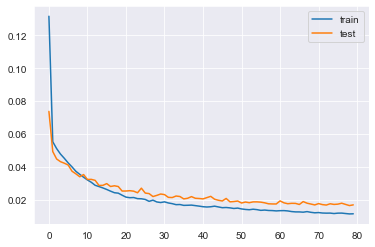

In [21]:
# plot 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['mse'], label='mse') #to mse einai idio me to loss
plt.legend()
plt.show()


#### define an encoder model (without the decoder) & save to file

In [22]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
#plot_model(encoder, 'encoder_compressG1.png', show_shapes=True)
# save the encoder to file
#encoder.save('encoder_halfG1.tf')

#### define an encoder model (without the decoder) & save to file

In [23]:
from numpy import asarray
from numpy import save
from numpy import load
from numpy import isnan

from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

In [25]:
#see output dimensions
a= np.unique(y) 
a

array([0., 1., 2., 3., 4.])

In [28]:
# encode the train data
X_train_encode = encoder.predict(X_train)

# encode the test data
X_test_encode = encoder.predict(X_test)

print(X_train_encode.shape,X_test_encode.shape)

#bilding NN with best hyperparameters found in gridsearch with batch normalization
best_model = Sequential()

best_model.add(Dense(32, 
                kernel_initializer='he_normal', 
                activation='relu'))
       
for i in range(3): # Add 3 hidden layers
    best_model.add(Dense(32, 
                    kernel_initializer='he_normal',
                    activation='relu'))

best_model.add(Dropout(rate=0.5))         
# Add output layer 
best_model.add(Dense(5, activation='softmax'))
    
    # Compile model
best_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy'])

#fit NN with data encoded with encoder model
history2 = best_model.fit(X_train_encode,y_train, batch_size=16, epochs=40, verbose=0,validation_split=0.3)

#make prediction
y_classes =best_model.predict_classes(X_test_encode,verbose=1)

#print accracy of NN model to see if encoder enhanced performance, which it didn't
print('Accuracy score for encoder: %.3f ' % accuracy_score(y_test,y_classes))

(1470, 334) (368, 334)
368/368 [==============================] - 0s 190us/sample
Accuracy score for encoder: 0.829 


In [29]:
print(history2.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


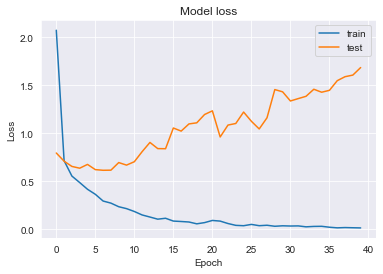

In [30]:
# plot learning curves
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

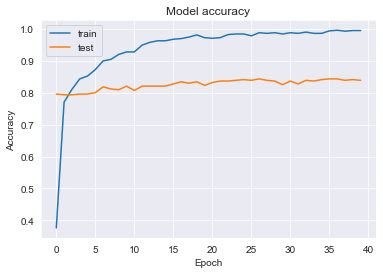

In [31]:
# plot learning curves
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history2.history['sparse_categorical_accuracy'], label='train')
plt.plot(history2.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.show()

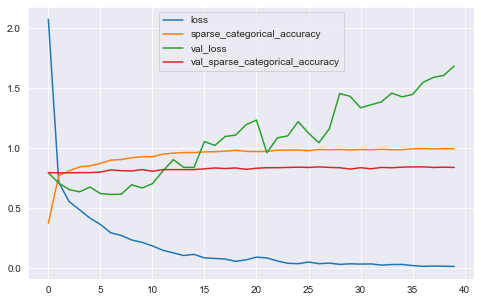

In [32]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.show()

In [33]:
print('\n',confusion_matrix(y_test, y_classes))
print('\n',classification_report(y_test, y_classes))
print('\n Cohen\'s kappa: ',cohen_kappa_score(y_test, y_classes))


 [[284  19   0   0   0]
 [ 34  14   0   0   0]
 [  2   4   4   1   1]
 [  0   0   1   1   1]
 [  0   0   0   0   2]]

               precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       303
         1.0       0.38      0.29      0.33        48
         2.0       0.80      0.33      0.47        12
         3.0       0.50      0.33      0.40         3
         4.0       0.50      1.00      0.67         2

    accuracy                           0.83       368
   macro avg       0.61      0.58      0.56       368
weighted avg       0.81      0.83      0.82       368


 Cohen's kappa:  0.36679958485825104


In [34]:
%run -i show_confusion_matrix.py

<Figure size 432x288 with 0 Axes>

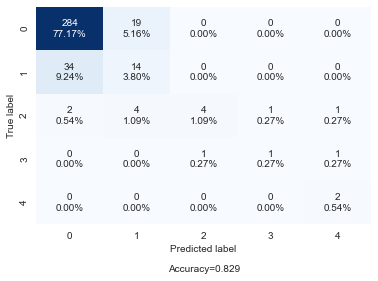

In [35]:
cf_matrix = confusion_matrix(y_test, y_classes)
#plot confusion matrix with percentages an numbers
make_confusion_matrix(cf_matrix, figsize=(6,4), cbar=False)